#### Read in data and get a subsample to test on

In [1]:
import csv
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import Counter
import io
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

max_vocab_size = 10000
PAD_IDX = 0
UNK_IDX = 1
MAX_SENTENCE_LENGTH = 200

In [2]:
torch.cuda.is_available()

True

In [3]:
if torch.cuda.is_available():
    cuda = torch.device('cuda')
else:
    cuda = torch.device('cpu')

In [4]:
cuda

device(type='cuda')

In [5]:
train = pd.read_csv('hw2_data/snli_train.tsv', delimiter='\t')
val = pd.read_csv('hw2_data/snli_val.tsv', delimiter='\t')

In [6]:
train.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [7]:
train.shape

(100000, 3)

In [8]:
val.shape

(1000, 3)

In [9]:
train_sub, val_sub = train.iloc[0:100000,], val.iloc[0:1000,]

In [10]:
train_sub_s1, train_sub_s2, train_sub_label = np.array(train_sub['sentence1']), np.array(train_sub['sentence2']), np.array(train_sub['label'])
val_sub_s1, val_sub_s2, val_sub_label = np.array(val_sub['sentence1']), np.array(val_sub['sentence2']), np.array(val_sub['label'])


In [11]:
label_map = {"neutral":0, "entailment":1, 'contradiction':2}
train_sub_nlabel = []
val_sub_nlabel = []

for l in train_sub_label:
    train_sub_nlabel.append(label_map[l])
    
for v in val_sub_label:
    val_sub_nlabel.append(label_map[v])

Tokenize input sentences. Use code from Homework1

In [12]:
def tokenize_ngram_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        ngram = sample.split()
        tokens = []
        for gram in ngram:
            tokens.append(gram)
        
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [13]:
train_data_s1_token, all_train_tokens_s1 = tokenize_ngram_dataset(train_sub_s1)
train_data_s2_token, all_train_tokens_s2 = tokenize_ngram_dataset(train_sub_s2)
all_train_tokens = all_train_tokens_s1 + all_train_tokens_s2
val_data_s1_token, _ = tokenize_ngram_dataset(val_sub_s1)
val_data_s2_token, _ = tokenize_ngram_dataset(val_sub_s2)

Build vocab, code from lab3

In [15]:
s1_length = []
for s in train_sub_s1:
    s1_length.append(len(s))
    
np.mean(s1_length), np.max(s1_length)

(67.52648, 406)

In [16]:
def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [17]:
len(token2id)

10002

In [18]:
token_id = {}
for i, word in enumerate(id2token):
    token_id[word] = i

In [20]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_s1_indices = token2index_dataset(train_data_s1_token)
train_s2_indices = token2index_dataset(train_data_s2_token)
val_s1_indices = token2index_dataset(val_data_s1_token)
val_s2_indices = token2index_dataset(val_data_s2_token)

In [21]:
train_s1_indices[0]

[4, 24, 25, 5, 3, 106, 26, 33, 9, 3, 740, 1976, 3, 363, 12, 52, 2]

#### Load Fasttext word embedding

Load pretrained embedding code from [Fasttext website](https://fasttext.cc/docs/en/english-vectors.html)

In [22]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:]).astype(float)
    return data

In [23]:
pretrained_emb = load_vectors('wiki-news-300d-1M.vec')

Check if words from vocabulary are in the pretrained embedding vocabulary. If not, initialize with a random vector with the same size. Code referenced from [this blog post on Medium](https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76). 

In [25]:
def load_weight_matrix(vocab, pretrained_emb):
    matrix_len = len(vocab)
    weights_matrix = np.zeros((matrix_len, 300))
    words_found = 0
    for i, word in enumerate(vocab):
        try: 
            weights_matrix[i] = pretrained_emb[word]
            words_found += 1
            
        except KeyError:
            weights_matrix[i] = np.random.rand(300, ) - 0.5
    
    return weights_matrix

In [26]:
weights_matrix = load_weight_matrix(token_id, pretrained_emb)

In [27]:
weights_matrix.shape

(10002, 300)

#### Build pytorch dataloader

Data from Lab3.

In [29]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data1, data2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data1 = data1
        self.data2 = data2
        self.target_list = target_list
        assert (len(self.data1) == len(self.target_list))
        assert (len(self.data2) == len(self.target_list))

    def __len__(self):
        return len(self.data1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        s1_idx = self.data1[key][:MAX_SENTENCE_LENGTH]
        s2_idx = self.data2[key][:MAX_SENTENCE_LENGTH]
        
        label = self.target_list[key]
        
        return [s1_idx, s2_idx, len(s1_idx), len(s2_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data1 = []
    data2 = []
    s1_length = []
    s2_length = []
    label_list = []
    
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        s1_length.append(datum[2])
        s2_length.append(datum[3])
        label_list.append(datum[4])
    # padding
    for datum in batch:
        padded_vec_s1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data1.append(padded_vec_s1)
        data2.append(padded_vec_s2)
    
    return [torch.from_numpy(np.array(data1)), torch.from_numpy(np.array(data2)), torch.LongTensor(s1_length), torch.LongTensor(s2_length), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_s1_indices, train_s2_indices, train_sub_nlabel)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

val_dataset = NewsGroupDataset(val_s1_indices, val_s2_indices, val_sub_nlabel)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [40]:
for s1, s2, length1, length2, labels in train_loader:
    print(s1[1].shape)
    break

torch.Size([200])


### CNN Model

In [32]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        
        # s1
        self.embedding1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # s2
        self.embedding2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.linear1 = nn.Linear(hidden_size, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        # CNN for s1
        embed1 = self.embedding1(s1)
        #print(embed1.shape)
        #print(embed1[0, 0, ])
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))

        #print(hidden1.shape)
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        #print(hidden1.shape)
        hidden1 = self.pool1(hidden1.transpose(1,2)).transpose(1,2)
        #print(hidden1.shape)
        # CNN for s2
        embed2 = self.embedding2(s2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))

        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        
        hidden2 = self.pool2(hidden2.transpose(1,2)).transpose(1,2)
        
        # concat
        hidden = torch.cat((hidden1, hidden2), 1)
        
        # fully connected layer
        hidden = torch.sum(hidden, dim=1)
        #hidden = hidden.view(-1, 200*100)
        #print(hidden.shape)
        
        fc1 = F.leaky_relu(self.linear1(hidden))
        #print(fc1.shape)
        #print(fc1)
        fc2 = self.linear2(fc1)
        #print(fc2.shape)
        #print(fc2)
        
        return fc2

In [34]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length1, length2, labels in loader:
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.to(device=cuda).size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
    return (100 * correct / total)

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = CNN(emb_size=300, hidden_size=128, num_layers=2, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.0001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
#model.embedding.weight.requires_grad=False
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_cnn_bs = []
val_accuracy_cnn_bs = []
train_accuracy_cnn_bs_step = []
val_accuracy_cnn_bs_step = []
train_loss_cnn_bs = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            train_accuracy_cnn_bs_step.append(train_acc)
            val_accuracy_cnn_bs_step.append(val_acc)
            learning_rate = learning_rate / 2
    train_loss_cnn_bs.append(loss)
    train_accuracy_cnn_bs.append(train_acc)
    val_accuracy_cnn_bs.append(val_acc)
    

Epoch: [1/10], Step: [301/3125], Loss:1.1101996898651123, Train Acc: 40.341, Validation Acc: 39.5
Epoch: [1/10], Step: [601/3125], Loss:1.0005863904953003, Train Acc: 52.868, Validation Acc: 50.0
Epoch: [1/10], Step: [901/3125], Loss:0.9207687973976135, Train Acc: 55.142, Validation Acc: 54.9
Epoch: [1/10], Step: [1201/3125], Loss:0.8832209706306458, Train Acc: 59.479, Validation Acc: 58.4
Epoch: [1/10], Step: [1501/3125], Loss:1.0570422410964966, Train Acc: 60.951, Validation Acc: 61.8
Epoch: [1/10], Step: [1801/3125], Loss:0.8029327988624573, Train Acc: 61.95, Validation Acc: 61.1
Epoch: [1/10], Step: [2101/3125], Loss:0.6984254717826843, Train Acc: 62.995, Validation Acc: 61.8
Epoch: [1/10], Step: [2401/3125], Loss:0.7652971744537354, Train Acc: 63.548, Validation Acc: 62.3
Epoch: [1/10], Step: [2701/3125], Loss:0.7159364223480225, Train Acc: 64.486, Validation Acc: 63.0
Epoch: [1/10], Step: [3001/3125], Loss:0.7496470808982849, Train Acc: 63.934, Validation Acc: 61.6
Epoch: [2/10],

Epoch: [9/10], Step: [1501/3125], Loss:0.7002530097961426, Train Acc: 78.748, Validation Acc: 64.4
Epoch: [9/10], Step: [1801/3125], Loss:0.47789275646209717, Train Acc: 78.677, Validation Acc: 64.5
Epoch: [9/10], Step: [2101/3125], Loss:0.2706952393054962, Train Acc: 78.95, Validation Acc: 64.0
Epoch: [9/10], Step: [2401/3125], Loss:0.4392419755458832, Train Acc: 79.077, Validation Acc: 64.2
Epoch: [9/10], Step: [2701/3125], Loss:0.4278813302516937, Train Acc: 79.348, Validation Acc: 64.0
Epoch: [9/10], Step: [3001/3125], Loss:0.5826925039291382, Train Acc: 79.432, Validation Acc: 64.5
Epoch: [10/10], Step: [301/3125], Loss:0.3860337734222412, Train Acc: 78.681, Validation Acc: 64.0
Epoch: [10/10], Step: [601/3125], Loss:0.46245989203453064, Train Acc: 79.881, Validation Acc: 64.7
Epoch: [10/10], Step: [901/3125], Loss:0.3952195644378662, Train Acc: 79.776, Validation Acc: 65.8
Epoch: [10/10], Step: [1201/3125], Loss:0.5058633089065552, Train Acc: 80.223, Validation Acc: 65.0
Epoch: [

In [35]:
np.max(val_accuracy_cnn_bs_step)

66.3

In [37]:
val_accuracy_cnn_bs

[61.6, 64.1, 63.6, 63.2, 63.8, 64.2, 63.9, 64.6, 64.5, 64.2]

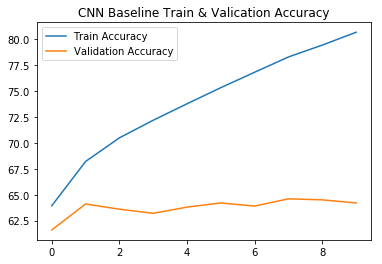

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(10), train_accuracy_cnn_bs, label="Train Accuracy")
plt.plot(range(10), val_accuracy_cnn_bs, label="Validation Accuracy")
plt.title('CNN Baseline Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

### RNN


In [43]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        # s1
        self.embedding_s1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
        self.rnn_s1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #s2
        self.embedding_s2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
        self.rnn_s2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # fully connected
        self.linear1 = nn.Linear(hidden_size * 2, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden_s1 = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        hidden_s2 = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)

        return hidden_s1.to(device=cuda), hidden_s2.to(device=cuda)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        self.hidden_s1, self.hidden_s2 = self.init_hidden(batch_size)

        # get embedding of characters
        embed1 = self.embedding_s1(s1)
        embed2 = self.embedding_s2(s2)
        embed1.to(device=cuda)
        embed2.to(device=cuda)
        # s1
        rnn_out_s1, hidden1 = self.rnn_s1(embed1, self.hidden_s1)
        # s2
        rnn_out_s2, hidden2 = self.rnn_s2(embed2, self.hidden_s2)
        
        
        # concat
        hidden = torch.cat((hidden1[1,:,:], hidden2[1,:,:]), 1)
        #print(hidden.shape)
        
        # sum hidden activations of RNN across time
        #hidden = torch.sum(rnn_out, dim=1)

        fc1 = F.leaky_relu(self.linear1(hidden))
        #print(fc1.shape)
        fc2 = self.linear2(fc1)
        #print(fc2.shape)
        
        
#         # test
#         rnn_out_s1 = torch.sum(rnn_out_s1, dim=1)
#         rnn_out_s2 = torch.sum(rnn_out_s2, dim=1)
        
#         rnn_out = torch.cat((rnn_out_s1, rnn_out_s2), 1)
#         fc1 = F.relu(self.linear1(rnn_out))
#         #print(fc1.shape)
#         fc2 = self.linear2(fc1)
        #print(fc2.shape)
        
        return fc2


In [44]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length1, length2, labels in loader:
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.to(device=cuda).size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
    return (100 * correct / total)

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = GRU(emb_size=300, hidden_size=128, num_layers=1, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.0001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_rnn_bs = []
val_accuracy_rnn_bs = []
train_accuracy_rnn_bs_step = []
val_accuracy_rnn_bs_step = []
train_loss_rnn_bs = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 500 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            train_accuracy_rnn_bs_step.append(train_acc)
            val_accuracy_rnn_bs_step.append(val_acc)
    #learning_rate = learning_rate / (epoch + 5)
    train_loss_rnn_bs.append(loss)
    train_accuracy_rnn_bs.append(train_acc)
    val_accuracy_rnn_bs.append(val_acc)


Epoch: [1/10], Step: [501/3125], Loss:1.0148911476135254, Train Acc: 47.247, Validation Acc: 47.1
Epoch: [1/10], Step: [1001/3125], Loss:0.9446134567260742, Train Acc: 54.827, Validation Acc: 54.5
Epoch: [1/10], Step: [1501/3125], Loss:1.0480369329452515, Train Acc: 60.502, Validation Acc: 60.0
Epoch: [1/10], Step: [2001/3125], Loss:0.9274342656135559, Train Acc: 61.993, Validation Acc: 59.8
Epoch: [1/10], Step: [2501/3125], Loss:0.7993497848510742, Train Acc: 63.389, Validation Acc: 63.1
Epoch: [1/10], Step: [3001/3125], Loss:0.6949728727340698, Train Acc: 64.502, Validation Acc: 63.5
Epoch: [2/10], Step: [501/3125], Loss:0.790681004524231, Train Acc: 65.337, Validation Acc: 63.4
Epoch: [2/10], Step: [1001/3125], Loss:0.8480149507522583, Train Acc: 65.717, Validation Acc: 63.3
Epoch: [2/10], Step: [1501/3125], Loss:1.1106740236282349, Train Acc: 66.46, Validation Acc: 63.0
Epoch: [2/10], Step: [2001/3125], Loss:0.802873432636261, Train Acc: 66.866, Validation Acc: 62.6
Epoch: [2/10], 

In [45]:
np.max(val_accuracy_rnn_bs_step)

65.2

In [46]:
pkl.dump(model, open("rnn_bl.p", "wb"))

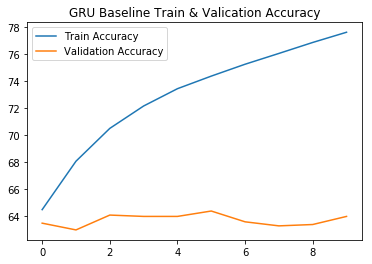

In [47]:
plt.plot(range(10), train_accuracy_rnn_bs, label="Train Accuracy")
plt.plot(range(10), val_accuracy_rnn_bs, label="Validation Accuracy")
plt.title('GRU Baseline Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

## CNN Tuning

### Kernal Size

#### kernel = 1

With updated learning rate. 

In [52]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        
        # s1
        self.embedding1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # s2
        self.embedding2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=1, padding=0)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=1, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.linear1 = nn.Linear(hidden_size, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        # CNN for s1
        embed1 = self.embedding1(s1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.pool1(hidden1.transpose(1,2)).transpose(1,2)
        
        # CNN for s2
        embed2 = self.embedding2(s2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.pool2(hidden2.transpose(1,2)).transpose(1,2)
        
        # concat
        hidden = torch.cat((hidden1, hidden2), 1)
        
        # fully connected layer
        hidden = torch.sum(hidden, dim=1)
        
        fc1 = F.leaky_relu(self.linear1(hidden))
        fc2 = self.linear2(fc1)
        
        return fc2

In [53]:
# Kernal size of 1
# decay learning rate: every 100 step, learning rate divide by 2

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = CNN(emb_size=300, hidden_size=128, num_layers=2, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.00005
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
#model.embedding.weight.requires_grad=False
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_cnn_kernel1 = []
val_accuracy_cnn_kernel1 = []
train_accuracy_cnn_kernel1_step = []
val_accuracy_cnn_kernel1_step = []
train_loss_cnn_kernel1 = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            learning_rate = learning_rate / 2
            train_accuracy_cnn_kernel1_step.append(train_acc)
            val_accuracy_cnn_kernel1_step.append(val_acc)
            
    train_loss_cnn_kernel1.append(loss)
    train_accuracy_cnn_kernel1.append(train_acc)
    val_accuracy_cnn_kernel1.append(val_acc)

Epoch: [1/10], Step: [101/3125], Loss:1.0820207595825195, Train Acc: 33.658, Validation Acc: 33.1
Epoch: [1/10], Step: [201/3125], Loss:1.082746148109436, Train Acc: 33.166, Validation Acc: 33.1
Epoch: [1/10], Step: [301/3125], Loss:1.1352232694625854, Train Acc: 33.2, Validation Acc: 33.8
Epoch: [1/10], Step: [401/3125], Loss:1.1196582317352295, Train Acc: 36.171, Validation Acc: 35.6
Epoch: [1/10], Step: [501/3125], Loss:1.1077055931091309, Train Acc: 33.187, Validation Acc: 33.0
Epoch: [1/10], Step: [601/3125], Loss:1.0779314041137695, Train Acc: 33.2, Validation Acc: 33.8
Epoch: [1/10], Step: [701/3125], Loss:1.0390561819076538, Train Acc: 36.58, Validation Acc: 35.0
Epoch: [1/10], Step: [801/3125], Loss:1.0239763259887695, Train Acc: 41.584, Validation Acc: 38.9
Epoch: [1/10], Step: [901/3125], Loss:1.0548137426376343, Train Acc: 41.349, Validation Acc: 41.0
Epoch: [1/10], Step: [1001/3125], Loss:1.071858286857605, Train Acc: 42.963, Validation Acc: 43.2
Epoch: [1/10], Step: [1101

Epoch: [3/10], Step: [2301/3125], Loss:0.8264389038085938, Train Acc: 65.169, Validation Acc: 62.5
Epoch: [3/10], Step: [2401/3125], Loss:0.6929820775985718, Train Acc: 64.851, Validation Acc: 61.2
Epoch: [3/10], Step: [2501/3125], Loss:0.7714446783065796, Train Acc: 64.945, Validation Acc: 63.4
Epoch: [3/10], Step: [2601/3125], Loss:0.9531541466712952, Train Acc: 65.063, Validation Acc: 62.3
Epoch: [3/10], Step: [2701/3125], Loss:0.6706242561340332, Train Acc: 65.406, Validation Acc: 62.9
Epoch: [3/10], Step: [2801/3125], Loss:1.0954965353012085, Train Acc: 65.478, Validation Acc: 62.4
Epoch: [3/10], Step: [2901/3125], Loss:0.7501875162124634, Train Acc: 64.95, Validation Acc: 61.3
Epoch: [3/10], Step: [3001/3125], Loss:0.7068557739257812, Train Acc: 65.43, Validation Acc: 62.3
Epoch: [3/10], Step: [3101/3125], Loss:0.9930294156074524, Train Acc: 65.641, Validation Acc: 62.3
Epoch: [4/10], Step: [101/3125], Loss:0.7493298053741455, Train Acc: 65.462, Validation Acc: 61.6
Epoch: [4/10]

Epoch: [6/10], Step: [1401/3125], Loss:0.5391983985900879, Train Acc: 68.835, Validation Acc: 62.3
Epoch: [6/10], Step: [1501/3125], Loss:0.9682724475860596, Train Acc: 68.8, Validation Acc: 62.7
Epoch: [6/10], Step: [1601/3125], Loss:0.7443903684616089, Train Acc: 68.666, Validation Acc: 62.2
Epoch: [6/10], Step: [1701/3125], Loss:0.7826471328735352, Train Acc: 68.909, Validation Acc: 62.2
Epoch: [6/10], Step: [1801/3125], Loss:0.6276172399520874, Train Acc: 68.818, Validation Acc: 62.4
Epoch: [6/10], Step: [1901/3125], Loss:0.8516975045204163, Train Acc: 68.787, Validation Acc: 61.5
Epoch: [6/10], Step: [2001/3125], Loss:0.754889726638794, Train Acc: 68.538, Validation Acc: 60.8
Epoch: [6/10], Step: [2101/3125], Loss:0.5057480931282043, Train Acc: 69.02, Validation Acc: 61.7
Epoch: [6/10], Step: [2201/3125], Loss:0.8672711253166199, Train Acc: 68.978, Validation Acc: 62.5
Epoch: [6/10], Step: [2301/3125], Loss:0.7476901412010193, Train Acc: 69.285, Validation Acc: 62.0
Epoch: [6/10],

Epoch: [9/10], Step: [501/3125], Loss:0.6648876667022705, Train Acc: 70.916, Validation Acc: 61.8
Epoch: [9/10], Step: [601/3125], Loss:0.82640141248703, Train Acc: 70.678, Validation Acc: 61.5
Epoch: [9/10], Step: [701/3125], Loss:0.7794131636619568, Train Acc: 70.251, Validation Acc: 61.5
Epoch: [9/10], Step: [801/3125], Loss:0.45956525206565857, Train Acc: 70.969, Validation Acc: 61.8
Epoch: [9/10], Step: [901/3125], Loss:0.6212722659111023, Train Acc: 71.116, Validation Acc: 61.7
Epoch: [9/10], Step: [1001/3125], Loss:0.78608638048172, Train Acc: 70.81, Validation Acc: 62.5
Epoch: [9/10], Step: [1101/3125], Loss:0.7158333659172058, Train Acc: 70.991, Validation Acc: 62.2
Epoch: [9/10], Step: [1201/3125], Loss:0.7562465667724609, Train Acc: 71.123, Validation Acc: 61.8
Epoch: [9/10], Step: [1301/3125], Loss:0.6599555611610413, Train Acc: 71.074, Validation Acc: 62.0
Epoch: [9/10], Step: [1401/3125], Loss:0.534591794013977, Train Acc: 70.417, Validation Acc: 61.1
Epoch: [9/10], Step:

In [54]:
np.max(val_accuracy_cnn_kernel1_step)

63.4

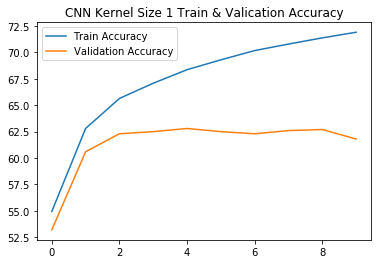

In [55]:
plt.plot(range(10), train_accuracy_cnn_kernel1, label="Train Accuracy")
plt.plot(range(10), val_accuracy_cnn_kernel1, label="Validation Accuracy")
plt.title('CNN Kernel Size 1 Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

#### kernel = 3

In [56]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        
        # s1
        self.embedding1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # s2
        self.embedding2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.linear1 = nn.Linear(hidden_size, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        # CNN for s1
        embed1 = self.embedding1(s1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.pool1(hidden1.transpose(1,2)).transpose(1,2)
        
        # CNN for s2
        embed2 = self.embedding2(s2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.pool2(hidden2.transpose(1,2)).transpose(1,2)
        
        # concat
        hidden = torch.cat((hidden1, hidden2), 1)
        
        # fully connected layer
        hidden = torch.sum(hidden, dim=1)
        
        fc1 = F.leaky_relu(self.linear1(hidden))
        fc2 = self.linear2(fc1)
        
        return fc2

In [57]:
# Kernal size of 3
# decay learning rate: every 100 step, learning rate divide by 2

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = CNN(emb_size=300, hidden_size=128, num_layers=2, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.00005
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
#model.embedding.weight.requires_grad=False
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_cnn_kernel3 = []
val_accuracy_cnn_kernel3 = []
train_accuracy_cnn_kernel3_step = []
val_accuracy_cnn_kernel3_step = []
train_loss_cnn_kernel3 = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            learning_rate = learning_rate / 2
            train_accuracy_cnn_kernel3_step.append(train_acc)
            val_accuracy_cnn_kernel3_step.append(val_acc)
            
    train_loss_cnn_kernel3.append(loss)
    train_accuracy_cnn_kernel3.append(train_acc)
    val_accuracy_cnn_kernel3.append(val_acc)

Epoch: [1/10], Step: [101/3125], Loss:1.0998554229736328, Train Acc: 39.26, Validation Acc: 37.7
Epoch: [1/10], Step: [201/3125], Loss:1.0660454034805298, Train Acc: 33.206, Validation Acc: 33.0
Epoch: [1/10], Step: [301/3125], Loss:1.1083030700683594, Train Acc: 36.838, Validation Acc: 35.5
Epoch: [1/10], Step: [401/3125], Loss:1.1536697149276733, Train Acc: 38.781, Validation Acc: 37.6
Epoch: [1/10], Step: [501/3125], Loss:1.0592551231384277, Train Acc: 40.884, Validation Acc: 38.5
Epoch: [1/10], Step: [601/3125], Loss:1.0557950735092163, Train Acc: 40.308, Validation Acc: 38.2
Epoch: [1/10], Step: [701/3125], Loss:0.9478192329406738, Train Acc: 39.273, Validation Acc: 37.8
Epoch: [1/10], Step: [801/3125], Loss:0.9419881105422974, Train Acc: 46.019, Validation Acc: 43.5
Epoch: [1/10], Step: [901/3125], Loss:1.0124937295913696, Train Acc: 43.655, Validation Acc: 44.0
Epoch: [1/10], Step: [1001/3125], Loss:1.0307254791259766, Train Acc: 50.493, Validation Acc: 48.5
Epoch: [1/10], Step:

Epoch: [3/10], Step: [2301/3125], Loss:0.7573878765106201, Train Acc: 67.266, Validation Acc: 63.2
Epoch: [3/10], Step: [2401/3125], Loss:0.6397732496261597, Train Acc: 66.977, Validation Acc: 63.1
Epoch: [3/10], Step: [2501/3125], Loss:0.6899265646934509, Train Acc: 66.869, Validation Acc: 63.1
Epoch: [3/10], Step: [2601/3125], Loss:0.9274373650550842, Train Acc: 67.256, Validation Acc: 63.1
Epoch: [3/10], Step: [2701/3125], Loss:0.6425539255142212, Train Acc: 67.595, Validation Acc: 63.7
Epoch: [3/10], Step: [2801/3125], Loss:1.0940061807632446, Train Acc: 67.698, Validation Acc: 64.0
Epoch: [3/10], Step: [2901/3125], Loss:0.7487210631370544, Train Acc: 67.345, Validation Acc: 62.9
Epoch: [3/10], Step: [3001/3125], Loss:0.6746938824653625, Train Acc: 67.566, Validation Acc: 63.6
Epoch: [3/10], Step: [3101/3125], Loss:0.9186103940010071, Train Acc: 67.5, Validation Acc: 64.0
Epoch: [4/10], Step: [101/3125], Loss:0.7544848322868347, Train Acc: 67.765, Validation Acc: 63.8
Epoch: [4/10]

Epoch: [6/10], Step: [1401/3125], Loss:0.49024802446365356, Train Acc: 70.791, Validation Acc: 62.9
Epoch: [6/10], Step: [1501/3125], Loss:0.9259762167930603, Train Acc: 71.001, Validation Acc: 63.4
Epoch: [6/10], Step: [1601/3125], Loss:0.7414677143096924, Train Acc: 70.826, Validation Acc: 62.7
Epoch: [6/10], Step: [1701/3125], Loss:0.7847782373428345, Train Acc: 70.968, Validation Acc: 63.3
Epoch: [6/10], Step: [1801/3125], Loss:0.6111653447151184, Train Acc: 71.028, Validation Acc: 63.7
Epoch: [6/10], Step: [1901/3125], Loss:0.7863222360610962, Train Acc: 71.064, Validation Acc: 62.6
Epoch: [6/10], Step: [2001/3125], Loss:0.6769452095031738, Train Acc: 70.738, Validation Acc: 63.2
Epoch: [6/10], Step: [2101/3125], Loss:0.4281834065914154, Train Acc: 71.002, Validation Acc: 63.0
Epoch: [6/10], Step: [2201/3125], Loss:0.7740981578826904, Train Acc: 71.013, Validation Acc: 62.1
Epoch: [6/10], Step: [2301/3125], Loss:0.6952790021896362, Train Acc: 71.293, Validation Acc: 63.9
Epoch: [6

Epoch: [9/10], Step: [501/3125], Loss:0.6438003778457642, Train Acc: 72.942, Validation Acc: 62.2
Epoch: [9/10], Step: [601/3125], Loss:0.6643544435501099, Train Acc: 73.048, Validation Acc: 63.3
Epoch: [9/10], Step: [701/3125], Loss:0.6715046763420105, Train Acc: 72.419, Validation Acc: 62.1
Epoch: [9/10], Step: [801/3125], Loss:0.40315571427345276, Train Acc: 73.353, Validation Acc: 63.6
Epoch: [9/10], Step: [901/3125], Loss:0.5624011158943176, Train Acc: 73.531, Validation Acc: 64.0
Epoch: [9/10], Step: [1001/3125], Loss:0.7386734485626221, Train Acc: 73.531, Validation Acc: 63.8
Epoch: [9/10], Step: [1101/3125], Loss:0.6974402666091919, Train Acc: 73.377, Validation Acc: 63.2
Epoch: [9/10], Step: [1201/3125], Loss:0.6843352317810059, Train Acc: 73.461, Validation Acc: 63.0
Epoch: [9/10], Step: [1301/3125], Loss:0.6614310145378113, Train Acc: 73.542, Validation Acc: 63.4
Epoch: [9/10], Step: [1401/3125], Loss:0.4477430582046509, Train Acc: 73.438, Validation Acc: 62.9
Epoch: [9/10],

In [58]:
max(val_accuracy_cnn_kernel3_step)

64.8

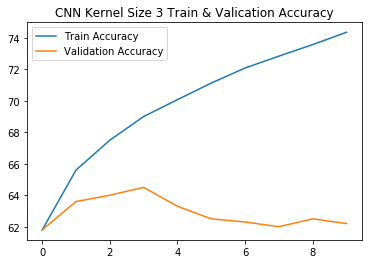

In [59]:
plt.plot(range(10), train_accuracy_cnn_kernel3, label="Train Accuracy")
plt.plot(range(10), val_accuracy_cnn_kernel3, label="Validation Accuracy")
plt.title('CNN Kernel Size 3 Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

#### kernel = 5

In [32]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        
        # s1
        self.embedding1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # s2
        self.embedding2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.linear1 = nn.Linear(hidden_size, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        # CNN for s1
        embed1 = self.embedding1(s1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.pool1(hidden1.transpose(1,2)).transpose(1,2)
        
        # CNN for s2
        embed2 = self.embedding2(s2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.pool2(hidden2.transpose(1,2)).transpose(1,2)
        
        # concat
        hidden = torch.cat((hidden1, hidden2), 1)
        
        # fully connected layer
        hidden = torch.sum(hidden, dim=1)
        
        fc1 = F.leaky_relu(self.linear1(hidden))
        fc2 = self.linear2(fc1)
        
        return fc2

In [34]:
# Kernal size of 5
# decay learning rate: every 100 step, learning rate divide by 2
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length1, length2, labels in loader:
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.to(device=cuda).size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
    return (100 * correct / total)

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = CNN(emb_size=300, hidden_size=128, num_layers=2, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.00005
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
#model.embedding.weight.requires_grad=False
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_cnn_kernel5 = []
val_accuracy_cnn_kernel5 = []
train_accuracy_cnn_kernel5_step = []
val_accuracy_cnn_kernel5_step = []
train_loss_cnn_kernel5 = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            learning_rate = learning_rate / 2
            train_accuracy_cnn_kernel5_step.append(train_acc)
            val_accuracy_cnn_kernel5_step.append(val_acc)
            
    train_loss_cnn_kernel5.append(loss)
    train_accuracy_cnn_kernel5.append(train_acc)
    val_accuracy_cnn_kernel5.append(val_acc)

Epoch: [1/10], Step: [301/3125], Loss:1.096231460571289, Train Acc: 42.731, Validation Acc: 41.0
Epoch: [1/10], Step: [601/3125], Loss:1.0429480075836182, Train Acc: 41.456, Validation Acc: 39.9
Epoch: [1/10], Step: [901/3125], Loss:0.9552744030952454, Train Acc: 48.374, Validation Acc: 49.0
Epoch: [1/10], Step: [1201/3125], Loss:0.9751160740852356, Train Acc: 55.25, Validation Acc: 53.7
Epoch: [1/10], Step: [1501/3125], Loss:1.0924774408340454, Train Acc: 56.365, Validation Acc: 56.8
Epoch: [1/10], Step: [1801/3125], Loss:0.8785032629966736, Train Acc: 58.934, Validation Acc: 58.2
Epoch: [1/10], Step: [2101/3125], Loss:0.7383782863616943, Train Acc: 59.698, Validation Acc: 58.2
Epoch: [1/10], Step: [2401/3125], Loss:0.8670641183853149, Train Acc: 59.481, Validation Acc: 58.1
Epoch: [1/10], Step: [2701/3125], Loss:0.7613320350646973, Train Acc: 61.748, Validation Acc: 61.5
Epoch: [1/10], Step: [3001/3125], Loss:0.7628923654556274, Train Acc: 61.283, Validation Acc: 61.1
Epoch: [2/10], 

Epoch: [9/10], Step: [1501/3125], Loss:0.8604029417037964, Train Acc: 74.905, Validation Acc: 64.3
Epoch: [9/10], Step: [1801/3125], Loss:0.5199841260910034, Train Acc: 75.546, Validation Acc: 64.3
Epoch: [9/10], Step: [2101/3125], Loss:0.3365399241447449, Train Acc: 75.404, Validation Acc: 63.8
Epoch: [9/10], Step: [2401/3125], Loss:0.5349050760269165, Train Acc: 75.692, Validation Acc: 64.4
Epoch: [9/10], Step: [2701/3125], Loss:0.5085439682006836, Train Acc: 75.738, Validation Acc: 64.3
Epoch: [9/10], Step: [3001/3125], Loss:0.5599762201309204, Train Acc: 75.483, Validation Acc: 63.2
Epoch: [10/10], Step: [301/3125], Loss:0.5222815871238708, Train Acc: 75.826, Validation Acc: 64.7
Epoch: [10/10], Step: [601/3125], Loss:0.5617051720619202, Train Acc: 75.31, Validation Acc: 63.4
Epoch: [10/10], Step: [901/3125], Loss:0.4767892062664032, Train Acc: 76.203, Validation Acc: 65.2
Epoch: [10/10], Step: [1201/3125], Loss:0.6434161067008972, Train Acc: 75.874, Validation Acc: 64.2
Epoch: [10

In [35]:
import pickle as pkl
pkl.dump(model, open("cnn_kernel5.p", "wb"))

In [36]:
np.max(val_accuracy_cnn_kernel5_step)

65.5

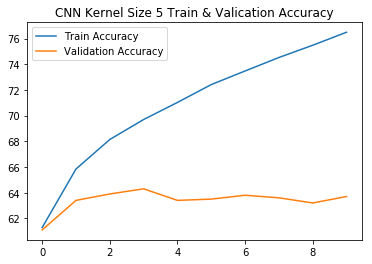

In [37]:
plt.plot(range(10), train_accuracy_cnn_kernel5, label="Train Accuracy")
plt.plot(range(10), val_accuracy_cnn_kernel5, label="Validation Accuracy")
plt.title('CNN Kernel Size 5 Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

### hidden dimension

#### hidden = 64

In [38]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        
        # s1
        self.embedding1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # s2
        self.embedding2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.linear1 = nn.Linear(hidden_size, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        # CNN for s1
        embed1 = self.embedding1(s1)
        #print(embed1.shape)
        #print(embed1[0, 0, ])
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))

        #print(hidden1.shape)
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        #print(hidden1.shape)
        hidden1 = self.pool1(hidden1.transpose(1,2)).transpose(1,2)
        #print(hidden1.shape)
        # CNN for s2
        embed2 = self.embedding2(s2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))

        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        
        hidden2 = self.pool2(hidden2.transpose(1,2)).transpose(1,2)
        
        # concat
        hidden = torch.cat((hidden1, hidden2), 1)
        
        # fully connected layer
        hidden = torch.sum(hidden, dim=1)
        #hidden = hidden.view(-1, 200*100)
        #print(hidden.shape)
        
        fc1 = F.leaky_relu(self.linear1(hidden))
        #print(fc1.shape)
        #print(fc1)
        fc2 = self.linear2(fc1)
        #print(fc2.shape)
        #print(fc2)
        
        return fc2

In [65]:
# Kernal size of 3
# decay learning rate: every 100 step, learning rate divide by 2

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = CNN(emb_size=300, hidden_size=64, num_layers=2, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.00005
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
#model.embedding.weight.requires_grad=False
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_cnn_hidden64 = []
val_accuracy_cnn_hidden64 = []
train_accuracy_cnn_hidden64_step = []
val_accuracy_cnn_hidden64_step = []
train_loss_cnn_hidden64 = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            learning_rate = learning_rate / 2
            train_accuracy_cnn_hidden64_step.append(train_acc)
            val_accuracy_cnn_hidden64_step.append(val_acc)
            
    train_loss_cnn_hidden64.append(loss)
    train_accuracy_cnn_hidden64.append(train_acc)
    val_accuracy_cnn_hidden64.append(val_acc)

Epoch: [1/10], Step: [101/3125], Loss:1.1078311204910278, Train Acc: 33.198, Validation Acc: 33.8
Epoch: [1/10], Step: [201/3125], Loss:1.0825107097625732, Train Acc: 33.166, Validation Acc: 33.1
Epoch: [1/10], Step: [301/3125], Loss:1.0961034297943115, Train Acc: 40.694, Validation Acc: 40.5
Epoch: [1/10], Step: [401/3125], Loss:1.118004560470581, Train Acc: 40.092, Validation Acc: 39.1
Epoch: [1/10], Step: [501/3125], Loss:1.0872071981430054, Train Acc: 33.619, Validation Acc: 33.7
Epoch: [1/10], Step: [601/3125], Loss:1.068311095237732, Train Acc: 41.205, Validation Acc: 38.4
Epoch: [1/10], Step: [701/3125], Loss:1.006252408027649, Train Acc: 40.582, Validation Acc: 38.3
Epoch: [1/10], Step: [801/3125], Loss:0.9878209829330444, Train Acc: 42.961, Validation Acc: 39.6
Epoch: [1/10], Step: [901/3125], Loss:1.0337793827056885, Train Acc: 43.83, Validation Acc: 43.5
Epoch: [1/10], Step: [1001/3125], Loss:1.0026886463165283, Train Acc: 45.216, Validation Acc: 42.5
Epoch: [1/10], Step: [1

Epoch: [3/10], Step: [2301/3125], Loss:0.7663158774375916, Train Acc: 66.389, Validation Acc: 63.5
Epoch: [3/10], Step: [2401/3125], Loss:0.6986640691757202, Train Acc: 66.305, Validation Acc: 63.2
Epoch: [3/10], Step: [2501/3125], Loss:0.7253724932670593, Train Acc: 65.991, Validation Acc: 63.4
Epoch: [3/10], Step: [2601/3125], Loss:0.9071404337882996, Train Acc: 66.326, Validation Acc: 62.9
Epoch: [3/10], Step: [2701/3125], Loss:0.6438138484954834, Train Acc: 66.623, Validation Acc: 63.2
Epoch: [3/10], Step: [2801/3125], Loss:1.1349862813949585, Train Acc: 66.707, Validation Acc: 64.1
Epoch: [3/10], Step: [2901/3125], Loss:0.7456250190734863, Train Acc: 66.575, Validation Acc: 63.3
Epoch: [3/10], Step: [3001/3125], Loss:0.670579195022583, Train Acc: 66.696, Validation Acc: 63.4
Epoch: [3/10], Step: [3101/3125], Loss:0.9346523284912109, Train Acc: 66.552, Validation Acc: 63.6
Epoch: [4/10], Step: [101/3125], Loss:0.7475897669792175, Train Acc: 66.685, Validation Acc: 63.2
Epoch: [4/10

Epoch: [6/10], Step: [1401/3125], Loss:0.4922635555267334, Train Acc: 69.842, Validation Acc: 63.8
Epoch: [6/10], Step: [1501/3125], Loss:0.936783492565155, Train Acc: 70.065, Validation Acc: 64.6
Epoch: [6/10], Step: [1601/3125], Loss:0.7497575879096985, Train Acc: 70.038, Validation Acc: 62.8
Epoch: [6/10], Step: [1701/3125], Loss:0.8351564407348633, Train Acc: 70.214, Validation Acc: 63.3
Epoch: [6/10], Step: [1801/3125], Loss:0.6215798854827881, Train Acc: 70.13, Validation Acc: 63.3
Epoch: [6/10], Step: [1901/3125], Loss:0.7921996712684631, Train Acc: 70.224, Validation Acc: 63.2
Epoch: [6/10], Step: [2001/3125], Loss:0.7096927165985107, Train Acc: 70.044, Validation Acc: 63.3
Epoch: [6/10], Step: [2101/3125], Loss:0.45759305357933044, Train Acc: 70.24, Validation Acc: 63.4
Epoch: [6/10], Step: [2201/3125], Loss:0.8484914898872375, Train Acc: 70.261, Validation Acc: 63.2
Epoch: [6/10], Step: [2301/3125], Loss:0.7260669469833374, Train Acc: 70.411, Validation Acc: 63.1
Epoch: [6/10

Epoch: [9/10], Step: [501/3125], Loss:0.6645697951316833, Train Acc: 72.117, Validation Acc: 62.1
Epoch: [9/10], Step: [601/3125], Loss:0.7458784580230713, Train Acc: 71.986, Validation Acc: 63.0
Epoch: [9/10], Step: [701/3125], Loss:0.714196503162384, Train Acc: 71.764, Validation Acc: 62.7
Epoch: [9/10], Step: [801/3125], Loss:0.46021074056625366, Train Acc: 72.362, Validation Acc: 63.2
Epoch: [9/10], Step: [901/3125], Loss:0.5671374201774597, Train Acc: 72.539, Validation Acc: 64.3
Epoch: [9/10], Step: [1001/3125], Loss:0.7782356142997742, Train Acc: 72.447, Validation Acc: 63.3
Epoch: [9/10], Step: [1101/3125], Loss:0.6589435935020447, Train Acc: 72.506, Validation Acc: 62.6
Epoch: [9/10], Step: [1201/3125], Loss:0.7085703611373901, Train Acc: 72.635, Validation Acc: 63.4
Epoch: [9/10], Step: [1301/3125], Loss:0.6750635504722595, Train Acc: 72.616, Validation Acc: 62.9
Epoch: [9/10], Step: [1401/3125], Loss:0.47487086057662964, Train Acc: 72.257, Validation Acc: 62.7
Epoch: [9/10],

In [66]:
np.max(val_accuracy_cnn_hidden64_step)

64.7

In [ ]:
pkl.dump(model, open("cnn_hidden64.p", "wb"))

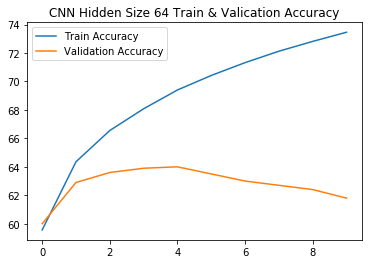

In [67]:
plt.plot(range(10), train_accuracy_cnn_hidden64, label="Train Accuracy")
plt.plot(range(10), val_accuracy_cnn_hidden64, label="Validation Accuracy")
plt.title('CNN Hidden Size 64 Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

#### hidden = 256

In [39]:
# Kernal size of 3
# decay learning rate: every 100 step, learning rate divide by 2

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = CNN(emb_size=300, hidden_size=256, num_layers=2, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.00005
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
#model.embedding.weight.requires_grad=False
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_cnn_hidden256 = []
val_accuracy_cnn_hidden256 = []
train_accuracy_cnn_hidden256_step = []
val_accuracy_cnn_hidden256_step = []
train_loss_cnn_hidden256 = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            learning_rate = learning_rate / 2
            train_accuracy_cnn_hidden256_step.append(train_acc)
            val_accuracy_cnn_hidden256_step.append(val_acc)
            
    train_loss_cnn_hidden256.append(loss)
    train_accuracy_cnn_hidden256.append(train_acc)
    val_accuracy_cnn_hidden256.append(val_acc)

Epoch: [1/10], Step: [301/3125], Loss:1.096360683441162, Train Acc: 37.279, Validation Acc: 36.1
Epoch: [1/10], Step: [601/3125], Loss:1.073195457458496, Train Acc: 39.931, Validation Acc: 39.1
Epoch: [1/10], Step: [901/3125], Loss:0.9823819994926453, Train Acc: 46.375, Validation Acc: 46.7
Epoch: [1/10], Step: [1201/3125], Loss:0.9873695373535156, Train Acc: 53.297, Validation Acc: 51.9
Epoch: [1/10], Step: [1501/3125], Loss:1.0264180898666382, Train Acc: 56.48, Validation Acc: 54.8
Epoch: [1/10], Step: [1801/3125], Loss:0.8846191167831421, Train Acc: 57.292, Validation Acc: 54.9
Epoch: [1/10], Step: [2101/3125], Loss:0.7700456380844116, Train Acc: 59.498, Validation Acc: 58.7
Epoch: [1/10], Step: [2401/3125], Loss:0.8710182905197144, Train Acc: 59.961, Validation Acc: 59.3
Epoch: [1/10], Step: [2701/3125], Loss:0.770188570022583, Train Acc: 61.157, Validation Acc: 61.7
Epoch: [1/10], Step: [3001/3125], Loss:0.7487549781799316, Train Acc: 61.644, Validation Acc: 61.3
Epoch: [2/10], St

Epoch: [9/10], Step: [1501/3125], Loss:0.8414774537086487, Train Acc: 74.843, Validation Acc: 64.7
Epoch: [9/10], Step: [1801/3125], Loss:0.5031760334968567, Train Acc: 75.316, Validation Acc: 65.3
Epoch: [9/10], Step: [2101/3125], Loss:0.33171290159225464, Train Acc: 75.048, Validation Acc: 63.3
Epoch: [9/10], Step: [2401/3125], Loss:0.4921027719974518, Train Acc: 75.245, Validation Acc: 63.9
Epoch: [9/10], Step: [2701/3125], Loss:0.5281922817230225, Train Acc: 75.546, Validation Acc: 64.2
Epoch: [9/10], Step: [3001/3125], Loss:0.5724422335624695, Train Acc: 75.504, Validation Acc: 63.8
Epoch: [10/10], Step: [301/3125], Loss:0.46274423599243164, Train Acc: 75.186, Validation Acc: 65.0
Epoch: [10/10], Step: [601/3125], Loss:0.5785147547721863, Train Acc: 75.599, Validation Acc: 64.7
Epoch: [10/10], Step: [901/3125], Loss:0.5271328687667847, Train Acc: 75.993, Validation Acc: 65.0
Epoch: [10/10], Step: [1201/3125], Loss:0.6306429505348206, Train Acc: 75.948, Validation Acc: 65.4
Epoch: 

In [40]:
np.max(val_accuracy_cnn_hidden256_step)

65.4

In [41]:
pkl.dump(model, open("cnn_hidden256.p", "wb"))

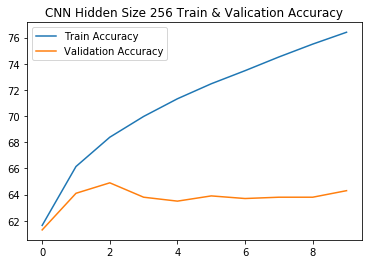

In [42]:
plt.plot(range(10), train_accuracy_cnn_hidden256, label="Train Accuracy")
plt.plot(range(10), val_accuracy_cnn_hidden256, label="Validation Accuracy")
plt.title('CNN Hidden Size 256 Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

## RNN Tuning

### Hidden Dimension

#### hidden = 64

In [48]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length1, length2, labels in loader:
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.to(device=cuda).size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
    return (100 * correct / total)

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = GRU(emb_size=300, hidden_size=64, num_layers=1, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.0001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_rnn_hidden64 = []
val_accuracy_rnn_hidden64 = []
train_accuracy_rnn_hidden64_step = []
val_accuracy_rnn_hidden64_step = []
train_loss_rnn_hidden64 = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 500 iterations
        if i > 0 and i % 500 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            train_accuracy_rnn_hidden64_step.append(train_acc)
            val_accuracy_rnn_hidden64_step.append(val_acc)
    
    train_loss_rnn_hidden64.append(loss)
    train_accuracy_rnn_hidden64.append(train_acc)
    val_accuracy_rnn_hidden64.append(val_acc)


Epoch: [1/10], Step: [501/3125], Loss:1.0079169273376465, Train Acc: 46.785, Validation Acc: 47.1
Epoch: [1/10], Step: [1001/3125], Loss:0.9366946816444397, Train Acc: 55.13, Validation Acc: 54.8
Epoch: [1/10], Step: [1501/3125], Loss:1.0319106578826904, Train Acc: 60.141, Validation Acc: 60.1
Epoch: [1/10], Step: [2001/3125], Loss:0.9197457432746887, Train Acc: 61.967, Validation Acc: 61.3
Epoch: [1/10], Step: [2501/3125], Loss:0.831159770488739, Train Acc: 63.258, Validation Acc: 62.4
Epoch: [1/10], Step: [3001/3125], Loss:0.7182646989822388, Train Acc: 64.185, Validation Acc: 62.4
Epoch: [2/10], Step: [501/3125], Loss:0.7905289530754089, Train Acc: 65.167, Validation Acc: 63.7
Epoch: [2/10], Step: [1001/3125], Loss:0.8207758665084839, Train Acc: 65.453, Validation Acc: 63.2
Epoch: [2/10], Step: [1501/3125], Loss:1.0670790672302246, Train Acc: 66.205, Validation Acc: 63.0
Epoch: [2/10], Step: [2001/3125], Loss:0.8261665105819702, Train Acc: 66.593, Validation Acc: 63.1
Epoch: [2/10],

In [49]:
np.max(val_accuracy_rnn_hidden64_step)

64.9

In [50]:
pkl.dump(model, open("rnn_hidden64.p", "wb"))

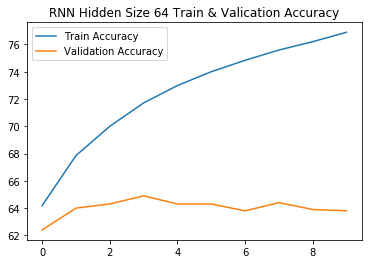

In [51]:
plt.plot(range(10), train_accuracy_rnn_hidden64, label="Train Accuracy")
plt.plot(range(10), val_accuracy_rnn_hidden64, label="Validation Accuracy")
plt.title('RNN Hidden Size 64 Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

#### hidden = 256

In [52]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length1, length2, labels in loader:
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.to(device=cuda).size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
    return (100 * correct / total)

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = GRU(emb_size=300, hidden_size=256, num_layers=1, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
model.to(device=cuda)

learning_rate = 0.0001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_rnn_hidden256 = []
val_accuracy_rnn_hidden256 = []
train_accuracy_rnn_hidden256_step = []
val_accuracy_rnn_hidden256_step = []
train_loss_rnn_hidden256 = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 500 iterations
        if i > 0 and i % 500 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            train_accuracy_rnn_hidden256_step.append(train_acc)
            val_accuracy_rnn_hidden256_step.append(val_acc)
    
    train_loss_rnn_hidden256.append(loss)
    train_accuracy_rnn_hidden256.append(train_acc)
    val_accuracy_rnn_hidden256.append(val_acc)


Epoch: [1/10], Step: [501/3125], Loss:1.0198872089385986, Train Acc: 48.278, Validation Acc: 47.7
Epoch: [1/10], Step: [1001/3125], Loss:0.9594362378120422, Train Acc: 54.618, Validation Acc: 54.1
Epoch: [1/10], Step: [1501/3125], Loss:1.0395472049713135, Train Acc: 60.328, Validation Acc: 60.0
Epoch: [1/10], Step: [2001/3125], Loss:0.9026451110839844, Train Acc: 62.08, Validation Acc: 60.4
Epoch: [1/10], Step: [2501/3125], Loss:0.7641360759735107, Train Acc: 63.817, Validation Acc: 62.8
Epoch: [1/10], Step: [3001/3125], Loss:0.6786437630653381, Train Acc: 64.857, Validation Acc: 62.8
Epoch: [2/10], Step: [501/3125], Loss:0.8279382586479187, Train Acc: 65.547, Validation Acc: 63.4
Epoch: [2/10], Step: [1001/3125], Loss:0.8637452721595764, Train Acc: 66.233, Validation Acc: 63.1
Epoch: [2/10], Step: [1501/3125], Loss:1.1071813106536865, Train Acc: 66.869, Validation Acc: 63.0
Epoch: [2/10], Step: [2001/3125], Loss:0.7855353355407715, Train Acc: 67.399, Validation Acc: 62.7
Epoch: [2/10]

In [53]:
np.max(val_accuracy_rnn_hidden256_step)

65.4

In [54]:
pkl.dump(model, open("rnn_hidden256.p", "wb"))

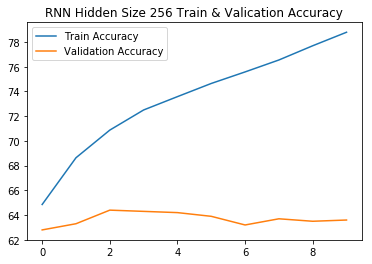

In [55]:
plt.plot(range(10), train_accuracy_rnn_hidden256, label="Train Accuracy")
plt.plot(range(10), val_accuracy_rnn_hidden256, label="Validation Accuracy")
plt.title('RNN Hidden Size 256 Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

#### Dropout

In [56]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights, dropout):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        self.dropout = dropout
        # s1
        self.embedding_s1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
        self.rnn_s1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #s2
        self.embedding_s2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
        self.rnn_s2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # fully connected
        self.linear1 = nn.Linear(hidden_size * 2, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden_s1 = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        hidden_s2 = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)

        return hidden_s1.to(device=cuda), hidden_s2.to(device=cuda)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        self.hidden_s1, self.hidden_s2 = self.init_hidden(batch_size)

        # get embedding of characters
        embed1 = self.embedding_s1(s1)
        embed2 = self.embedding_s2(s2)
        embed1.to(device=cuda)
        embed2.to(device=cuda)
        # s1
        rnn_out_s1, hidden1 = self.rnn_s1(embed1, self.hidden_s1)
        # s2
        rnn_out_s2, hidden2 = self.rnn_s2(embed2, self.hidden_s2)
        
        
        # concat
        hidden = torch.cat((hidden1[1,:,:], hidden2[1,:,:]), 1)

        fc1 = F.leaky_relu(self.linear1(hidden))
        fc2 = self.linear2(fc1)
        
        return fc2


In [57]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length1, length2, labels in loader:
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.to(device=cuda).size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
    return (100 * correct / total)

weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
model = GRU(emb_size=300, hidden_size=128, num_layers=1, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix, dropout=0.1)
model.to(device=cuda)

learning_rate = 0.0001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss().to(device=cuda)
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad==True], lr=learning_rate)

# Train the model
total_step = len(train_loader)
train_accuracy_rnn_drop = []
val_accuracy_rnn_drop = []
train_accuracy_rnn_drop_step = []
val_accuracy_rnn_drop_step = []
train_loss_rnn_drop = []

for epoch in range(num_epochs):
    for i, (s1, s2, length1, length2, labels) in enumerate(train_loader):
        #print(s1)
        model.train()
        #model.embedding.weight.requires_grad=False
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        #predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, labels.to(device=cuda))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 500 iterations
        if i > 0 and i % 500 == 0:
            # validate
            train_acc=test_model(train_loader, model)
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Loss:{}, Train Acc: {}, Validation Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader),loss, train_acc, val_acc))
            train_accuracy_rnn_drop_step.append(train_acc)
            val_accuracy_rnn_drop_step.append(val_acc)
    #learning_rate = learning_rate / (epoch + 5)
    train_loss_rnn_drop.append(loss)
    train_accuracy_rnn_drop.append(train_acc)
    val_accuracy_rnn_drop.append(val_acc)


Epoch: [1/10], Step: [501/3125], Loss:1.0093004703521729, Train Acc: 46.413, Validation Acc: 46.7
Epoch: [1/10], Step: [1001/3125], Loss:0.9653025269508362, Train Acc: 52.46, Validation Acc: 51.9
Epoch: [1/10], Step: [1501/3125], Loss:1.0336377620697021, Train Acc: 58.365, Validation Acc: 58.2
Epoch: [1/10], Step: [2001/3125], Loss:0.9305292963981628, Train Acc: 61.259, Validation Acc: 60.2
Epoch: [1/10], Step: [2501/3125], Loss:0.8098441362380981, Train Acc: 62.992, Validation Acc: 63.2
Epoch: [1/10], Step: [3001/3125], Loss:0.6907694935798645, Train Acc: 64.222, Validation Acc: 62.9
Epoch: [2/10], Step: [501/3125], Loss:0.8202027678489685, Train Acc: 65.065, Validation Acc: 64.4
Epoch: [2/10], Step: [1001/3125], Loss:0.8731988668441772, Train Acc: 65.523, Validation Acc: 63.7
Epoch: [2/10], Step: [1501/3125], Loss:1.1015526056289673, Train Acc: 66.352, Validation Acc: 63.3
Epoch: [2/10], Step: [2001/3125], Loss:0.7767603993415833, Train Acc: 66.75, Validation Acc: 63.2
Epoch: [2/10],

In [62]:
np.max(val_accuracy_rnn_drop_step)

66.5

In [59]:
pkl.dump(model, open("rnn_dropout.p", "wb"))

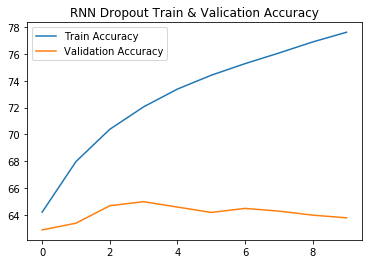

In [60]:
plt.plot(range(10), train_accuracy_rnn_drop, label="Train Accuracy")
plt.plot(range(10), val_accuracy_rnn_drop, label="Validation Accuracy")
plt.title('RNN Dropout Train & Valication Accuracy')
plt.legend(loc = 'best')
plt.show()

Save model dict

In [61]:
torch.save(model.state_dict(),"rnn_dropout")

### Best model on validation 

#### CNN

In [30]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        
        # s1
        self.embedding1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        # s2
        self.embedding2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
    
        self.conv3 = nn.Conv1d(emb_size, hidden_size, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.linear1 = nn.Linear(hidden_size, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        # CNN for s1
        embed1 = self.embedding1(s1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len, hidden1.size(-1))
        hidden1 = self.pool1(hidden1.transpose(1,2)).transpose(1,2)
        
        # CNN for s2
        embed2 = self.embedding2(s2)
        hidden2 = self.conv3(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.conv4(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len, hidden2.size(-1))
        hidden2 = self.pool2(hidden2.transpose(1,2)).transpose(1,2)
        
        # concat
        hidden = torch.cat((hidden1, hidden2), 1)
        
        # fully connected layer
        hidden = torch.sum(hidden, dim=1)
        
        fc1 = F.leaky_relu(self.linear1(hidden))
        fc2 = self.linear2(fc1)
        
        return fc2

In [31]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, length1, length2, labels in loader:
        outputs = model(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.to(device=cuda).size(0)
        correct += predicted.eq(labels.to(device=cuda).view_as(predicted)).sum().item()
    return (100 * correct / total)

In [32]:
import pickle as pkl
cnn_model = pkl.load(open("cnn_kernel5.p", "rb"))
torch.save(cnn_model.state_dict(),"cnnmodel")
weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
best_cnn = CNN(emb_size=300, hidden_size=128, num_layers=2, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix)
best_cnn.load_state_dict(torch.load('cnnmodel'))

In [33]:
cnn_model.eval()
cnn_model.to(device=cuda)

CNN(
  (embedding1): Embedding(10002, 300, padding_idx=0)
  (conv1): Conv1d(300, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (embedding2): Embedding(10002, 300, padding_idx=0)
  (conv3): Conv1d(300, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=128, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=3, bias=True)
)

In [34]:
test_model(val_loader, cnn_model)

64.4

In [68]:
for i, (s1, s2, length1, length2, label) in enumerate(val_loader):
    outputs = best_cnn(s1, s2, length1)
    outputs = F.softmax(outputs, dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    correct = predicted.eq(label.view_as(predicted))
    break

In [69]:
correct

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.uint8)

In [71]:
predicted

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [2],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0]])

In [70]:
val.head(8)

,sentence1,sentence2,label
0,"Three women on a stage , one wearing red shoes...",There are two women standing on the stage,contradiction
1,"Four people sit on a subway two read books , o...","Multiple people are on a subway together , wit...",entailment
2,bicycles stationed while a group of people soc...,People get together near a stand of bicycles .,entailment
3,Man in overalls with two horses .,a man in overalls with two horses,entailment
4,Man observes a wavelength given off by an elec...,The man is examining what wavelength is given ...,entailment
5,Two people are in a green forest .,The forest is not dead .,entailment
6,Two men are listening to music through headpho...,Two men listen to music .,entailment
7,"Two women , one walking her dog the other push...",There is a snowstorm .,contradiction


#### RNN

In [30]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, fc_classes, num_classes, vocab_size, weights, dropout):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.weights = Variable(torch.Tensor(weights), requires_grad=False)
        self.fc_classes = fc_classes
        self.num_classes = num_classes
        self.dropout = dropout
        # s1
        self.embedding_s1 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
        self.rnn_s1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #s2
        self.embedding_s2 = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX, _weight=weights)
        self.rnn_s2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # fully connected
        self.linear1 = nn.Linear(hidden_size * 2, fc_classes)
        self.linear2 = nn.Linear(fc_classes, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden_s1 = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)
        hidden_s2 = torch.randn(self.num_layers * 2, batch_size, self.hidden_size)

        return hidden_s1.to(device=cuda), hidden_s2.to(device=cuda)

    def forward(self, s1, s2, length1):
        batch_size, seq_len = s1.size()

        self.hidden_s1, self.hidden_s2 = self.init_hidden(batch_size)

        # get embedding of characters
        embed1 = self.embedding_s1(s1)
        embed2 = self.embedding_s2(s2)
        embed1.to(device=cuda)
        embed2.to(device=cuda)
        # s1
        rnn_out_s1, hidden1 = self.rnn_s1(embed1, self.hidden_s1)
        # s2
        rnn_out_s2, hidden2 = self.rnn_s2(embed2, self.hidden_s2)
        
        
        # concat
        hidden = torch.cat((hidden1[1,:,:], hidden2[1,:,:]), 1)

        fc1 = F.leaky_relu(self.linear1(hidden))
        fc2 = self.linear2(fc1)
        
        return fc2


In [32]:
weightsmatrix = Variable(torch.Tensor(weights_matrix), requires_grad=False)
best_rnn = GRU(emb_size=300, hidden_size=128, num_layers=1, fc_classes=48, num_classes=3, vocab_size=len(id2token), weights=weightsmatrix, dropout=0.1)
best_rnn.load_state_dict(torch.load('rnn_dropout'))

In [35]:
best_rnn.eval()

GRU(
  (embedding_s1): Embedding(10002, 300, padding_idx=0)
  (rnn_s1): GRU(300, 128, batch_first=True, bidirectional=True)
  (embedding_s2): Embedding(10002, 300, padding_idx=0)
  (rnn_s2): GRU(300, 128, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=256, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=3, bias=True)
)

In [38]:
best_rnn.to(device=cuda)

GRU(
  (embedding_s1): Embedding(10002, 300, padding_idx=0)
  (rnn_s1): GRU(300, 128, batch_first=True, bidirectional=True)
  (embedding_s2): Embedding(10002, 300, padding_idx=0)
  (rnn_s2): GRU(300, 128, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=256, out_features=48, bias=True)
  (linear2): Linear(in_features=48, out_features=3, bias=True)
)

In [41]:
for i, (s1, s2, length1, length2, label) in enumerate(val_loader):
    #outputs = best_rnn(s1, s2, length1)
    outputs = best_rnn(s1.to(device=cuda).long(), s2.to(device=cuda).long(), length1.to(device=cuda).long())
    outputs = F.softmax(outputs, dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    correct = predicted.eq(label.to(device=cuda).view_as(predicted))
    break

In [42]:
correct

tensor([[0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], device='cuda:0', dtype=torch.uint8)

In [43]:
predicted

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [2],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [2],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0]], device='cuda:0')